**STEP 0: SETUP**
*   Setup the environment here.
*   Install/Import libraries as needed.
*   Mount drive(s)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import absolute_import, division, print_function
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot  as plt
from google.colab import files
print(tf.__version__)

2.15.0


In [ ]:
#!pip install torch

In [ ]:
import yfinance as yf

In [ ]:
!pip install pandas-ta
import pandas_ta as pta

In [ ]:
!pip install ta
import ta
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#df = {'Open': 1445.700012, 'High':1456.500000,'Low':1426.549988, 'Close' : 1427.000012,	'Adj Close':1427.700012,'Volume':	20872940}
#data = data._append(pd.DataFrame(df, index=['2024-05-09 00:00:00']))

**STEP 1: PREPROCESSING**
*   Fetch Data and process it to derive more data
*   Cleanup the data to make it ready for the next step


In [ ]:
tkr = 'CANBK.NS'
data = yf.download(tkr, start='2019-01-01', end='2024-12-31')
#data = yf.download(tkr, start='2023-01-01', end='2023-07-20')
data

In [ ]:
psar_obj = ta.trend.PSARIndicator(data['High'],data['Low'],data['Close'], fillna=True)
df = psar_obj.psar()
df1 = psar_obj.psar_up()
df2 = psar_obj.psar_down()
df.rename('ta-psar', inplace=True)
df1.rename('ta-psar-up', inplace=True)
df2.rename('ta-psar-dn', inplace=True)
data = pd.concat([data, df, df1, df2], axis=1)
#data[['ta-psar', 'ta-psar-up', 'ta-psar-dn']]

In [ ]:
#MACD uisng TA Pkg
macd_obj = ta.trend.MACD(data['Adj Close'])
data['ta-macd'] = macd_obj.macd()
data['ta-macd-sig'] = macd_obj.macd_signal()
data['ta-macd-sig-%'] = data['ta-macd']/data['ta-macd-sig']
#Histogram or diff is same
data['ta-macd-hgram'] = macd_obj.macd_diff()

#STC OSCILLATOR using PANDAS TA pkg
df = pta.stc(data['Adj Close'], fillna=False)
df.rename(columns={'STC_10_12_26_0.5':'pta-stc','STCmacd_10_12_26_0.5':'pta-stc-macd','STCstoch_10_12_26_0.5':'pta-stc-stoch' }, inplace=True)
data = pd.concat([data, df], axis=1)
data['pta-stc%-25'] = data['pta-stc']/25
data['pta-stc-stoch%-20'] = data['pta-stc-stoch']/20
#data


In [ ]:
#Calculate 'Up from 52 wk low' and 'down from 52 wk high'
def updn_52wk(df):
  max52 = df['Adj Close'].rolling(window=260).max().shift(1)
  min52 = df['Adj Close'].rolling(window=260).min().shift(1)
  dn = 1 - (df['Adj Close']/max52)
  up = (df['Adj Close']/min52) - 1
  return dn, up

data['dn52wk'], data['up52wk'] = updn_52wk(data)
#data

In [ ]:
#RSI using Pandas TA package
df1 = pta.rsi(data['Adj Close'])
df1.rename('pta-rsi', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-rsi%-25'] = data['pta-rsi']/25.0

#Stoch indicator using Pandas TA pkg
df = pta.stoch(data['High'],data['Low'],data['Close'])
df.rename(columns={'STOCHk_14_3_3':'pta-stochk','STOCHd_14_3_3':'pta-stochd'}, inplace=True)
data = pd.concat([data, df], axis=1)
data['pta-stochk%-20'] = data['pta-stochk']/20
data['pta-stochd%-20'] = data['pta-stochd']/20
#Stochastic Oscillator using TA pkg
stoch = StochasticOscillator(data['High'],data['Low'],data['Close'])
data['ta-stoch'] = stoch.stoch()
data['ta-stoch%-20'] = data['ta-stoch']/20

#AROON using Pandas TA pkg
df = pta.aroon(data['High'],data['Low'], length=25, talib=False, scalar = 1)
df.rename(columns={'AROOND_25':'pta-aroond','AROONU_25':'pta-aroonu','AROONOSC_25':'pta-aroon-osc'}, inplace=True)
data = pd.concat([data, df], axis=1)

In [ ]:
data

In [ ]:
# PTA Supertrend calculator
df = pta.supertrend(data['High'],data['Low'],data['Close'])
df.rename(columns={'SUPERT_7_3.0':'pta-supertrend','SUPERTd_7_3.0':'pta-supertrend-dir','SUPERTl_7_3.0':'pta-supertrend-l', 'SUPERTs_7_3.0':'pta-supertrend-s'}, inplace=True)
df = df.drop(['pta-supertrend-l','pta-supertrend-s'], axis=1)
data = pd.concat([data, df], axis=1)

In [ ]:
data

In [ ]:
#ADX using Pandas TA pkg
df = pta.adx(data['High'],data['Low'],data['Close'])
df.rename(columns={'ADX_14':'pta-adx','DMP_14':'pta-adx-dmp','DMN_14':'pta-adx-dmn'}, inplace=True)
data = pd.concat([data, df], axis=1)

data['pta-adx%-25'] = data['pta-adx']/25
data['pta-adx-pn%'] = data['pta-adx-dmp']/data['pta-adx-dmn']

#ATR using Pandas TA pkg
df1 = pta.atr(data['High'],data['Low'],data['Close'])
df1.rename('pta-atr', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-atr%'] = data['pta-atr']/data['Adj Close']

In [ ]:
data

In [ ]:
# Bollinger Bands using TA pkg
bollinger = BollingerBands(data['Adj Close'])
data['ta-boll-mva'] = bollinger.bollinger_mavg()
data['ta-boll-hband'] = bollinger.bollinger_hband()
data['ta-boll-lband'] = bollinger.bollinger_lband()
data['ta-boll-hb-ind'] = bollinger.bollinger_hband_indicator()
data['ta-boll-lb-ind'] = bollinger.bollinger_lband_indicator()
data['ta-boll-mva%'] = data['Adj Close']/data['ta-boll-mva']
data['ta-boll-hb%'] = data['Adj Close']/data['ta-boll-hband']
data['ta-boll-lb%'] = data['Adj Close']/data['ta-boll-lband']

#On Balance Vol
from ta.volume import OnBalanceVolumeIndicator
obv = OnBalanceVolumeIndicator(data['Adj Close'], data['Volume'])
data['ta-obv'] = obv.on_balance_volume()
data['ta-obv%'] = data['ta-obv']/data['ta-obv'].shift()

#VWAP Indicator from Pandas TA pkg
df = pta.vwap(data['High'],data['Low'],data['Close'], data['Volume'])
df1.rename('pta-vwap', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-vwap%'] = data['Adj Close']/data['pta-vwap']

In [ ]:
data['sma10'] = data['Adj Close'].rolling(10).mean()
data['sma30'] = data['Adj Close'].rolling(30).mean()
data['sma50'] = data['Adj Close'].rolling(50).mean()
data['sma200'] = data['Adj Close'].rolling(200).mean()
data['ema20'] = data['Adj Close'].ewm(span=20).mean()
data['ema200'] = data['Adj Close'].ewm(span=200).mean()

data['sma10%'] =  data['Adj Close']/data['sma10']
data['sma30%'] =  data['Adj Close']/data['sma30']
data['sma50%'] =  data['Adj Close']/data['sma50']
data['sma200%'] =  data['Adj Close']/data['sma200']
data['ema20%'] =  data['Adj Close']/data['ema20']
data['ema200%'] =  data['Adj Close']/data['ema200']

In [ ]:
plt.subplot(5,1,1)
plt.plot(data['ta-macd'])
plt.plot(data['ta-macd-sig'])
#plt.plot(data['ta-momentum'])
plt.plot(data['ta-macd-hgram'], color='grey', alpha = 0.5)

plt.subplot(5,1,2)
plt.plot(data['pta-rsi'], color='g')
plt.plot(data['ta-stoch'], color='b')
plt.plot(data['pta-stochk'], color='r')
#plt.plot(data['pta-stochd'], color='r')

plt.subplot(5,1,3)
plt.plot(data['pta-adx'], color='grey')
plt.plot(data['pta-adx-dmp'], color='b')
plt.plot(data['pta-adx-dmn'], color='r')
plt.plot(data['pta-atr'], color='y')

plt. subplot(5,1,4)
plt.plot(data['Adj Close'])
plt.plot(data['sma10'], color='grey')
plt.plot(data['sma30'], color='g')
#plt.plot(data['sma100'], color='r')
#plt.plot(data['ta-sma200'], color='y')

plt.subplot(5,1,5)
#plt.plot(data['ta-adi'], color='r')
plt.plot(data['ta-obv'], color='b')

data[['ta-boll-lband', 'ta-boll-mva', 'Adj Close', 'ta-boll-hband']].plot(style=['k--', 'c-', 'm-', 'k--'])
plt.plot(data[data['ta-boll-lb-ind']==1]['Adj Close'], '^g')
plt.plot(data[data['ta-boll-hb-ind']==1]['Adj Close'], 'vr')
#plt.title('Bollinger Bands Entries')



In [ ]:
data['Bullish_Run_Start'] = (data['ta-macd'] > data['ta-macd-sig']) & (data['ta-macd'].shift(1) <= data['ta-macd-sig'].shift(1))
data['Bearish_Run_Start'] = (data['ta-macd'] < data['ta-macd-sig']) & (data['ta-macd'].shift(1) >= data['ta-macd-sig'].shift(1))

In [ ]:
# Plot
plt.figure(figsize=(14, 10))

#Plot Close Price
plt.subplot(2, 1, 1)
plt.plot(data['sma10'], color = 'g')
plt.plot(data['sma30'], color = 'b')
plt.plot(data['Adj Close'], label='Adj Close Price')
plt.scatter(data.index[data['Bullish_Run_Start']], data['Adj Close'][data['Bullish_Run_Start']], marker='^', color='g', label='Start Bullish Run')
plt.scatter(data.index[data['Bearish_Run_Start']], data['Adj Close'][data['Bearish_Run_Start']], marker='v', color='r', label='Start Bearish Run')
plt.title(tkr + ' Stock Price and MACD')
plt.legend()


# Identify bullish and bearish crossover points
data['Bullish_Crossover'] = (data['ta-macd'] > data['ta-macd-sig']) & (data['ta-macd'].shift(1) <= data['ta-macd-sig'].shift(1))
data['Bearish_Crossover'] = (data['ta-macd'] < data['ta-macd-sig']) & (data['ta-macd'].shift(1) >= data['ta-macd-sig'].shift(1))

# Plot
plt.figure(figsize=(14, 10))

# Plot MACD
plt.subplot(2, 1, 2)
plt.plot(data['ta-macd'], label='MACD Line', color='blue', alpha=0.5)
plt.plot(data['ta-macd-sig'], label='Signal Line', color='red', alpha=0.5)
plt.bar(data.index, data['ta-macd-hgram'], label='Histogram', color='grey', alpha=0.5)

# Markers for bullish and bearish crossover
plt.scatter(data.index[data['Bullish_Crossover']], data['ta-macd'][data['Bullish_Crossover']], marker='^', color='g', label='Bullish Crossover')
plt.scatter(data.index[data['Bearish_Crossover']], data['ta-macd'][data['Bearish_Crossover']], marker='v', color='r', label='Bearish Crossover')
plt.plot(data['pta-rsi'], color='k')
plt.legend()
plt.show()

#plt.subplot(3,1,2)
#plt.plot(biocon['ta-macd'])
#plt.plot(biocon['ta-macd-sig'])
#plt.plot(biocon['ta-macd-diff'], color='grey', alpha = 0.5)
#plt. subplot(3,1,3)
#plt.plot(biocon['ta-rsi'], color='g')


In [ ]:
dta_copy = data.copy()
#data.dropna(inplace=True)

In [ ]:
#data = dta_copy.copy()
#data

In [ ]:
data.describe()

In [ ]:

data = data.drop(['ta-macd', 'ta-macd-sig', 'pta-stc', 'pta-stc-stoch'], axis = 1)
data = data.drop(['pta-rsi', 'ta-stoch','pta-stochk', 'pta-stochd'], axis = 1)
data = data.drop(['pta-adx-dmn', 'pta-adx','pta-adx-dmp', 'pta-atr'], axis = 1)
data = data.drop(['ta-boll-mva', 'ta-boll-hband','ta-boll-lband','ta-obv', 'pta-vwap'], axis = 1)
data = data.drop(['sma10', 'sma30','sma50','sma200', 'ema20','ema200', 'sma200%'], axis = 1)
data = data.drop(['Open', 'Close', 'High', 'Low','Bullish_Run_Start', 'Bearish_Run_Start', 'Bullish_Crossover', 'Bearish_Crossover'], axis = 1)
#data.dropna(inplace=True)
#data

In [ ]:
data = data.drop(['Volume', 'ta-psar-up', 'ta-psar-dn', 'pta-stc-macd','pta-supertrend', 'pta-supertrend-dir', 'ta-boll-hb-ind', 'ta-boll-lb-ind'], axis = 1)


In [ ]:
data = data.drop(['ta-boll-mva%', 'ta-boll-hb%','ta-boll-lb%','ta-obv%', 'pta-vwap%'], axis = 1)

In [ ]:
#data.dropna(inplace=True)
data.dtypes

In [ ]:
#function to create the output for ANN
def get_output(df, period=7):
  df['ret'] = df['Adj Close'].rolling(period).max().shift(-1*(period))
  #print(df)
  #df.dropna(inplace=True)
  df['ret%'] = df['ret'].sub(df['Adj Close']).div(df['Adj Close']).mul(100)
  df = df.drop('ret', axis=1)
  #df['ret%'] = df['ret%'].rolling(period).mean()
  return df

data = get_output(data, period=7)
data.dropna(inplace=True)

In [ ]:
plt.plot(data['ret%'])

In [ ]:
data

**STEP 2: TRAINING ANN**

In [ ]:
#Create a data copy to work during training and analysis
dta = data.copy()

In [ ]:
#data = dta.copy()
#data

In [ ]:
#pct_ret = data.pop('ret%')
#pct_ret

In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
#MinMaxScaler()
#price_scaled = scaler.transform(price)
#val_scaled = scaler.transform(val_set)
#test_scaled = scaler.transform(test_set)
data_scaled

**STEP 3: ANALYSIS**

In [ ]:
label = data_scaled[:,-1]
data_scaled = np.delete(data_scaled, -1,1)
label

In [ ]:
plt.plot(label)
#plt.plt(data_scaled[0])

In [ ]:
df = pd.DataFrame({'label':label})
global WINDOW_SIZE
WINDOW_SIZE = 50
y = df.shift(-1*(WINDOW_SIZE)).dropna().to_numpy()
y = y.flatten()

In [ ]:
def input_shape(df, window_size=50):
  #arr = df.to_numpy()
  #arr = df.flatten()
  arr = df
  X = []
  #y = []
  for i in range(len(arr) - window_size):
    row = [r for r in arr[i:i+window_size]]
    X.append(row)
    #label = arr[i+window_size][-3]
    #y.append(label)
  return np.array(X) #, np.array(y)

#WINDOW_SIZE = 50
X = input_shape(data_scaled, WINDOW_SIZE)
#X,y = input_shape(price, WINDOW_SIZE)
#y = label
X.shape, y.shape

((1006, 50, 23), (1006,))

In [ ]:
#length = np.floor(X.shape[0]*(0.95))
#length *= 0.9
#X_split = np.array_split(X, length)
#y_split = np.array_split(y, length)
X_train, y_train = X[:900], y[:900]
#X_val, y_val = X[800:900], y[800:900]
X_test, y_test = X[900:], y[900:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape #, X_val.shape, y_val.shape

((900, 50, 23), (900,), (106, 50, 23), (106,))

In [ ]:
def plot_predictions(model, X, y, start=0, end=100):
  #predictions = model.predict(X).flatten()
  predictions = model.predict(X)
  #predictions = scaler.inverse_transform(predictions)
  #y = scaler.inverse_transform(y.reshape(-1,1))
  #df = pd.DataFrame(data={"Predictions":predictions, "Actuals":y})
  plt.plot(predictions[start:end], color='red')
  plt.plot(y[start:end], color = 'green')
  return predictions, y
  #return predictions, y, mse(y,predictions), mae(y, predictions)

In [ ]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
input = X_train.shape[1]
features = X_train.shape[2]
model = Sequential()
#model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(input, features)))
#model.add(LSTM(64, activation='relu'))
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(input, features)))
model.add(GRU(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.callbacks import ModelCheckpoint
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10)
model.summary()

cp = ModelCheckpoint('model1/', monitor='mse', save_best_only=True, mode='max')

opt = tf.keras.optimizers.Adam(.005)
model.compile(loss='mse',
                optimizer=opt, metrics=['mae', 'mse'])

In [ ]:
class DotPrint(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print(" ")
    print('.',end='')

EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stop, cp])
#history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose = 0, callbacks=[DotPrint()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE(rets)')
  plt.plot(hist['epoch'], hist['mae'], label="Train Error")
  #plt.plot(hist['epoch'], hist['val_mae'], label="Validation Error")
  plt.legend()
  plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE($rets^2$)')
  plt.plot(hist['epoch'], hist['mse'], label="Train Error")
  #plt.plot(hist['epoch'], hist['val_mse'], label="Validation Error")
  plt.legend()
  plt.ylim([0,40])

plot_history(history)

25/25 [==============================] - 1s 14ms/step


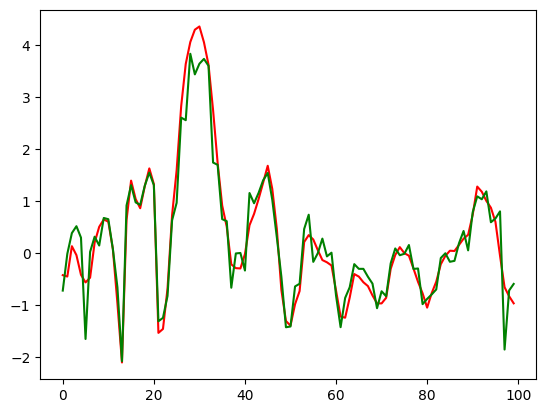

In [ ]:
pred, label = plot_predictions(model, X_train, y_train)
#predictions = model.predict(X_train)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
mserror = mse(label, pred)
maerror = mae(label, pred)
mserror, maerror
predict = pd.DataFrame({'pred': pred.flatten()})
lbl = pd.DataFrame({'label': label.flatten()})
#df = predict#pred = pd.DataFrame({'pred': pred.flatten()})
df = lbl.join(predict)

In [ ]:
maerror, mserror

(0.18836766864718377, 0.06411961826359107)

In [ ]:
df

In [ ]:
pred_test, label_test = plot_predictions(model, X_test, y_test)
#predictions = model.predict(X_train)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
mserror = mse(label_test, pred_test)
maerror = mae(label_test, pred_test)
mserror, maerror

In [ ]:
pred_all = np.append(pred, pred_test )
label_all = np.append(label, label_test)
#plt.plot(pred_all, color='red')
plt.plot(label_all, color = 'green')
plt.plot(pred_all, color = 'blue')
plt.plot(pred, color='red')

In [ ]:

preds = pred_all.reshape(-1,1)
predictions = np.empty((812,1))
predictions[:] = np.nan
predictions[50:] = preds
#predictions = preds.shift(-50)
data_scaled.shape, preds.shape, predictions.shape

((812, 40), (762, 1), (812, 1))

In [ ]:
data_pred = np.hstack((data_scaled, predictions))
unscaled_pred = scaler.inverse_transform(data_pred)

In [ ]:
unscaled_predictions = unscaled_pred[:,-1]
unscaled_predictions.shape, unscaled_pred.shape
#u_p = unscaled_predictions.reshape(-1,1)
#u_p.shape
p = pd.Series(unscaled_predictions)
#p.shape

In [ ]:
p.rename('pred rets', inplace=True)

In [ ]:
dta = pd.concat([dta, p], axis=1)

In [ ]:
dta

In [ ]:
rets = pd.DataFrame(data={"Predictions":pred_all.flatten(), "Actuals":label_all.flatten()})

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/")

In [ ]:
#save all the data to file for further analysis
dta.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4.csv")
rets.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4-rets.csv")

In [ ]:
p.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4-pred_rets_unscaled.csv")

**STEP 4: BACKTESTING**

**STEP 5: FINAL STEP**
*   Save data, files, script and model
*   

